# Running TCAV

This notebook walks you through an example application of the TCAV library step-by-step to understand which human interpretable concepts (e.g. stripes, dots, zigzags) are important to the image classifier GoogleNet's (a.k.a. Inception v1) prediction of Zebras.

## Install required packages

To run through this notebook in the interim, you are encouraged to utilize a `virtualenv` or `conda` environment for installing and working with the required packages to avoid any dependency and compatability issues with different versions of packages.

In [16]:
# pip install tensorflow
# pip install tcav

## Download example models and images

Open a terminal and run the following commands:

```
cd tcav/tcav_examples/image_models/imagenet

python download_and_make_datasets.py --source_dir=YOUR_PATH --number_of_images_per_folder=50 --number_of_random_folders=3
```

This script will download the following content into separate folders into a directory you specify with the `--source_dir=` argument:

**Images**
*  ImageNet images for the target Zebra class
*  [Broden dataset](http://netdissect.csail.mit.edu/) images for three concepts (e.g. striped, dotted, zigzagged)
*  Random ImageNet class images used by TCAV for hypothesis testing of important concepts

**Models**
*  [Inception 5h model](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/inception5h.py)
*  [Mobilenet V2 model](https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet_v1.md)

## Import extensions and libraries

In [17]:
#%load_ext autoreload
#%autoreload 2

In [18]:
import tcav.activation_generator as act_gen
import tcav.cav as cav
import tcav.model  as model
import tcav.tcav as tcav
import tcav.utils as utils
import tcav.utils_plot as utils_plot # utils_plot requires matplotlib
import os 
import tensorflow as tf

## TCAV step-by-step

You will walk through the following steps below:

1. **Store example images in each folder** (you have this if you ran the above)
 * images for each concept
 * images for the class/labels of interest
 * random images that will be negative examples when learning CAVs (images that probably don't belong to any concepts)
2. **Write a model wrapper** (below uses example from tcav/model.py)
 * an instance of  ModelWrapper abstract class (in model.py). This tells TCAV class (tcav.py) how to communicate with your model (e.g., getting internal tensors)
3. **Retrieve model activations** (below uses example from tcav/activation_generator.py)
 * an instance of ActivationGeneratorInterface that tells TCAV class how to load example data and how to get activations from the model
4. Run TCAV and visualize scores for important concepts.

## Step 1: Store concept and target class images to local folders

... and tell TCAV where they are.

**source_dir**: where images of concepts, target class and random images (negative samples when learning CAVs) live. Each should be a sub-folder within this directory.

Note that random image directories can be in any name. In this example, we are using `random500_0`, `random500_1`,.. for an arbitrary reason. 

You need roughly 50-200 images per concept and target class (10-20 pictures also tend to work, but 200 is pretty safe).


**cav_dir**: directory to store CAVs (`None` if you don't want to store)

**target, concept**: names of the target class (that you want to investigate) and concepts (strings) - these are folder names in source_dir

**bottlenecks**: list of bottleneck names (intermediate layers in your model) that you want to use for TCAV. These names are defined in the model wrapper below.



In [19]:
#print ('REMEMBER TO UPDATE YOUR_PATH (where images, models are)!')

# This is the name of your model wrapper (InceptionV3 and GoogleNet are provided in model.py)
model_to_run = 'GoogleNet'  


working_dir = "/Users/sebastianbitsch/Desktop/DeepLearning/tcav/tcav"
# where activations are stored (only if your act_gen_wrapper does so)
activation_dir =  working_dir+ '/activations/'
# where CAVs are stored. 
# You can say None if you don't wish to store any.
cav_dir = working_dir + '/cavs/'
# where the images live.

source_dir = '/Users/sebastianbitsch/Desktop/DeepLearning/tcav/tcav/tcav/tcav_examples/image_models/imagenet/folder01'
bottlenecks = ['mixed3a','mixed3b','mixed4a','mixed4b','mixed4c','mixed4d','mixed4e','mixed5a','mixed5b']
      
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(working_dir)
utils.make_dir_if_not_exists(cav_dir)

# this is a regularizer penalty parameter for linear classifier to get CAVs. 
alphas = [0.1]   

target = 'zebra'  
concepts = ["dotted","striped","zigzagged"]  


## Step 2: Write your model wrapper

The next step is to tell TCAV how to communicate with your model. See `model.GoogleNetWrapper_public ` for details.

You can define a subclass of ModelWrapper abstract class to do this. Let me walk you thru what each function does (tho they are pretty self-explanatory).  This wrapper includes a lot of the functions that you already have, for example, `get_prediction`.

### 2.1: Tensors from the graph: bottleneck tensors and ends
First, store your bottleneck tensors in `self.bottlenecks_tensors` as a dictionary. You only need bottlenecks that you are interested in running TCAV with. Similarly, fill in `self.ends` dictionary with `input`, `logit` and `prediction` tensors.

### 2.2: Define loss
Get your loss tensor, and assigned it to `self.loss`. This is what TCAV uses to take directional derivatives. 

While doing so, you would also want to set 
```python
self.y_input 
```
this simply is a tensorflow place holder for the target index in the logit layer (e.g., 0 index for a dog, 1 for a cat).
For multi-class classification, typically something like this works:

```python
self.y_input = tf.placeholder(tf.int64, shape=[None])
```

For example, for a multiclass classifier, something like below would work. 

```python
    # Construct gradient ops.
    with g.as_default():
      self.y_input = tf.placeholder(tf.int64, shape=[None])

      self.pred = tf.expand_dims(self.ends['prediction'][0], 0)

      self.loss = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits(
              labels=tf.one_hot(self.y_input, len(self.labels)),
              logits=self.pred))
    self._make_gradient_tensors()
```

### 2.3: Call _make_gradient_tensors in __init__() of your wrapper
```python
_make_gradient_tensors()  
```
does what you expect - given the loss and bottleneck tensors defined above, it adds gradient tensors.

### 2.4: Fill in labels, image shapes and a model name.
Get the mapping from labels (strings) to indice in the logit layer (int) in a dictionary format.

```python
def id_to_label(self, idx)
def label_to_id(self, label)
```

Set your input image shape at  `self.image_shape`


Set your model name to `self.model_name`

You are done with writing the model wrapper! See the two example model wrapers, InceptionV3 and Googlenet in `tcav/model.py`.

In [20]:
# Create TensorFlow session.
sess = utils.create_session()

# GRAPH_PATH is where the trained model is stored.
GRAPH_PATH = "/Users/sebastianbitsch/Desktop/DeepLearning/tcav/tcav/tcav/tcav_examples/image_models/imagenet/folder01/inception5h/tensorflow_inception_graph.pb"
# LABEL_PATH is where the labels are stored. Each line contains one class, and they are ordered with respect to their index in 
# the logit layer. (yes, id_to_label function in the model wrapper reads from this file.)
# For example, imagenet_comp_graph_label_strings.txt looks like:
# dummy                                                                                      
# kit fox
# English setter
# Siberian husky ...

LABEL_PATH = "/Users/sebastianbitsch/Desktop/DeepLearning/tcav/tcav/tcav/tcav_examples/image_models/imagenet/folder01/inception5h/imagenet_comp_graph_label_strings.txt"

mymodel = model.GoogleNetWrapper_public(sess,
                                        GRAPH_PATH,
                                        LABEL_PATH)

INFO:tensorflow:running zebra ['random500_7', 'random500_10']
INFO:tensorflow:Loaded /Users/sebastianbitsch/Desktop/DeepLearning/tcav/tcav/activations/acts_random500_7_mixed4c shape (6, 14, 14, 512)
INFO:tensorflow:Loaded /Users/sebastianbitsch/Desktop/DeepLearning/tcav/tcav/activations/acts_random500_10_mixed4c shape (9, 14, 14, 512)
INFO:tensorflow:Loaded /Users/sebastianbitsch/Desktop/DeepLearning/tcav/tcav/activations/acts_zebra_mixed4c shape (9, 14, 14, 512)
INFO:tensorflow:CAV already exists: /Users/sebastianbitsch/Desktop/DeepLearning/tcav/tcav/cavs/random500_7-random500_10-mixed4c-linear-0.1.pkl
INFO:tensorflow:CAV accuracies: {'random500_7': 1.0, 'random500_10': 0.0, 'overall': 0.5}


## Step 3: Implement a class that returns activations (maybe with caching!)

Lastly, you will implement a class of the ActivationGenerationInterface which TCAV uses to load example data for a given concept or target, call into your model wrapper and return activations. I pulled out this logic outside of mymodel because this step often takes the longest. By making it modular, you can cache your activations and/or parallelize your computations, as I have done in `ActivationGeneratorBase.process_and_load_activations` in `activation_generator.py`.


The `process_and_load_activations` method of the activation generator must return a dictionary of activations that has concept or target name as  a first key, and the bottleneck name as a second key. So something like:

```python
{concept1: {bottleneck1: [[0.2, 0.1, ....]]},
concept2: {bottleneck1: [[0.1, 0.02, ....]]},
target1: {bottleneck1: [[0.02, 0.99, ....]]}
```


In [21]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)

## Step 4: Run TCAV and visualize concept importance

You are now ready to run TCAV! Let's do it.

**num_random_exp**: number of experiments to confirm meaningful concept direction. TCAV will search for this many folders named `random500_0`, `random500_1`, etc. You can alternatively set the `random_concepts` keyword to be a list of folders of random concepts. Run at least 10-20 for meaningful tests. 

**random_counterpart**: as well as the above, you can optionally supply a single folder with random images as the "positive set" for statistical testing. Reduces computation time at the cost of less reliable random TCAV scores.


In [ ]:
import absl

absl.logging.set_verbosity(0)
num_random_exp = 3
## only running num_random_exp = 10 to save some time. The paper number are reported for 500 random runs. 
mytcav = tcav.TCAV(sess,
                   target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=num_random_exp)
print('This may take a while... Go get coffee!')
results = mytcav.run(run_parallel=True)
print('done!')

Class = zebra
  Concept = dotted
    Bottleneck = mixed3a. TCAV Score = 0.35 (+- 0.04), random was 0.48 (+- 0.12). p-val = 0.158 (not significant)
    Bottleneck = mixed3b. TCAV Score = 0.25 (+- 0.11), random was 0.50 (+- 0.19). p-val = 0.115 (not significant)
    Bottleneck = mixed4a. TCAV Score = 0.36 (+- 0.03), random was 0.60 (+- 0.16). p-val = 0.066 (not significant)
    Bottleneck = mixed4b. TCAV Score = 0.18 (+- 0.07), random was 0.44 (+- 0.14). p-val = 0.036 (significant)
    Bottleneck = mixed4c. TCAV Score = 0.59 (+- 0.28), random was 0.48 (+- 0.32). p-val = 0.664 (not significant)
    Bottleneck = mixed4d. TCAV Score = 0.64 (+- 0.11), random was 0.53 (+- 0.30). p-val = 0.630 (not significant)
    Bottleneck = mixed4e. TCAV Score = 0.62 (+- 0.27), random was 0.41 (+- 0.31). p-val = 0.420 (not significant)
    Bottleneck = mixed5a. TCAV Score = 0.81 (+- 0.14), random was 0.37 (+- 0.28). p-val = 0.057 (not significant)
    Bottleneck = mixed5b. TCAV Score = 0.38 (+- 0.19), rand

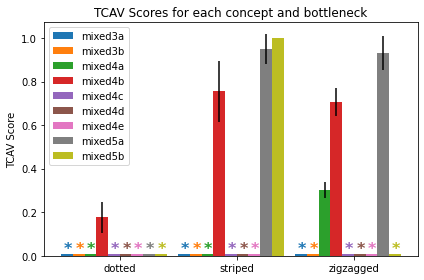

In [24]:
utils_plot.plot_results(results, num_random_exp=num_random_exp)

In [25]:
import json

with open("results_50im_3exp.json", "w") as outfile:
    json.dump(results, outfile)
